# AI and Blockchain: Spring 2024
## Lab 02 : Secure and Private AI 

<p><b>Instructions:</b> Complete the code in the designated cells, and upload the completed python notebook on LMS prefixed with your RCS ID, i.e., "senevo_lab02.ipynb". </p>

<p>Total points: <b>100</b></p>

<p>Assigned: <b>Feb 13, 2024</b></p>
<p>Due: <b>1:59 PM Mar 01, 2024</b></p>

<hr>

### Task 0: Please Type Your Information

RCS ID: 

Name: 

Level (4000/6000): 

Moskoj
Josh Moskoff
4000

## Differential Privacy with a Toy Dataset

Step one is to create our dataset, i.e., "database" - we will do this by initializing a random list of 1s and 0s (the entries in our database). Note - the number of entries directly corresponds to the number of people in our database.

In [363]:
import torch

num_entries = 5000
db = torch.rand(5000) > 0.5
db.int()[:10]

tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1], dtype=torch.int32)

In [364]:
db.shape

torch.Size([5000])

Key to the definition of differential privacy is the ability to ask the question, "When querying a database if I removed someone from the database, would the output of the query be any different?". To check this, we must construct what we term "parallel databases," which are simply databases with one entry removed.

### Task 1: Create parallel databases (2 points)

Create a list of every parallel database to the one currently in the "db" variable. The code to create a single parallel database is provided for you.

In [365]:
def get_parallel_db(db, remove_index):

    return torch.cat((db[0:remove_index],
                      db[remove_index+1:]))


def get_parallel_dbs(db):
    parallel_dbs = list()

    for i in range(len(db)):
        parallel_db = get_parallel_db(db, i)
        parallel_dbs.append(parallel_db)

    return parallel_dbs

Now, let's create the database and the parallels.

In [366]:
def create_db_and_parallels(num_entries):

    db = torch.rand(num_entries) > 0.5
    pdbs = get_parallel_dbs(db)
    return db, pdbs

## Evaluating The Differential Privacy of a Function

Let's make our first "database query" a simple sum by counting the number of 1s in the database.

In [367]:
db, pdbs = create_db_and_parallels(5000)

In [368]:
def query(db):
    return db.sum()

In [369]:
full_db_result = query(db)
full_db_result

tensor(2481)

In [370]:
pdb0_result = query(pdbs[0])
pdb0_result

tensor(2480)

In [371]:
sensitivity = 0
for pdb in pdbs:
    pdb_result = query(pdb)

    db_distance = torch.abs(pdb_result - full_db_result)

    if (db_distance > sensitivity):
        sensitivity = db_distance

In [372]:
sensitivity

tensor(1)

## Evaluating the Privacy of a Function

We can measure the difference between each parallel db's query result and the query result for the entire database by calculating the max value (1). This value is called "sensitivity," corresponding to the function we chose for the query. The "sum" query will always have a sensitivity of exactly 1. We can also calculate sensitivity for other functions. The steps for evaluating the sensitivity include the following:

* Initialize a database of the correct size
* Initialize all parallel databases
* Run the query over all databases
* Correctly calculate sensitivity
* Return the sensitivity

In [373]:
def sensitivity(query, n_entries=1000):

    db, pdbs = create_db_and_parallels(n_entries)

    full_db_result = query(db)

    max_distance = 0
    for pdb in pdbs:
        pdb_result = query(pdb)

        db_distance = torch.abs(pdb_result - full_db_result)

        if (db_distance > max_distance):
            max_distance = db_distance

    return max_distance

### Task 2: Calculate sensitivity for the "mean" function (3 points)

In [374]:
# Type your code here. You should print the sensitivity for mean
def meanSensitivity(db, pdbs):
    full_db_result = torch.mean(db)

    max_distance = 0
    for pdb in pdbs:
        pdb_result = torch.mean(pdb)

        db_distance = torch.abs(pdb_result - full_db_result)

        if (db_distance > max_distance):
            max_distance = db_distance

    return max_distance


num_entries = 1000
dbMean = torch.rand(num_entries)
pdbsMean = get_parallel_dbs(dbMean)
meanSensitivity(dbMean, pdbsMean)

tensor(0.0005)

## A Basic Differencing Attack

Let's construct a database and then demonstrate how you can use two different sum queries to expose the value of the person represented by row 10 in the database (note, you'll need to use a database with at least 10 rows)

In [375]:
db, _ = create_db_and_parallels(100)
pdb = get_parallel_db(db, remove_index=10)
db[10].int()
sum(db)
# differencing attack using sum query
print(sum(db) - sum(pdb))

tensor(0)


### Task 3: Demonstrate the differencing attack using the mean query (5 points)

In [376]:
# Type your code here
db = torch.rand(100)
pdb = get_parallel_db(db, remove_index=10)
# differencing attack using sum query
print(torch.abs(torch.mean(db) - torch.mean(pdb)))

tensor(0.0033)


## Local Differential Privacy
### Randomized Response

Let's say we have a group of people we wish to survey about a taboo behavior (e.g., nose picking, drug addiction, criminal behavior, cheating on their spouse) that we think they will lie about. 
We are not law enforcement; we are just trying to collect statistics to understand the higher-level trend in society using AI. 
So, how do we do this?

One technique is to add randomness to each person's response by giving each person the following instructions (assuming we are asking a simple yes/no question):

* Flip a coin two times.
* If the first coin flip is heads, answer honestly
* If the first coin flip is tails, answer according to the second coin flip (heads for yes, tails for no)!

Each person is now protected with "plausible deniability." If they answer "Yes" to the question "Have you committed X crime?", it might be because they actually did or because they are answering according to a random coin flip. Each person has a high degree of protection. Furthermore, we can recover the underlying statistics with some accuracy, as the "true statistics" are averaged with a 50% probability. Thus, if we collect a bunch of samples and it turns out that 60% of people answer yes, then we know that the TRUE distribution is centered around 70% because 70% averaged with 50% (a coin flip) is 60%, which is the result we obtained.

However, it should be noted that, especially when we only have a few samples, this comes at the cost of accuracy. This tradeoff exists across all of Differential Privacy. The greater the privacy protection (plausible deniability), the less accurate the results.

Let's implement this local DP for our database before!

In [377]:
def query(db):
    print(db)
    true_result = torch.mean(db.float())

    first_coin_flip = (torch.rand(len(db)) < 0.5).float()
    second_coin_flip = (torch.rand(len(db)) < 0.5).float()

    augmented_database = db.float() * first_coin_flip + \
        (1 - first_coin_flip) * second_coin_flip

    print(augmented_database)

    private_result = torch.mean(augmented_database.float()) * 2 - 0.5

    return private_result, true_result

### Task 4: Show how the private result (with noise) and the true result (without noise) change for databases of size 10, 100, 1000, and 10000. (5 points)
*Hint: Chart the results in a histogram for easy comparison.*

tensor([   10,   100,  1000, 10000])
tensor([0.2309, 0.8418, 0.9384, 0.7789, 0.6113, 0.9266, 0.0472, 0.8779, 0.2428,
        0.2078])
tensor([0.0000, 0.0000, 0.9384, 1.0000, 0.0000, 0.9266, 0.0472, 0.8779, 0.2428,
        0.0000])
tensor([0.2574, 0.9609, 0.8170, 0.9028, 0.0214, 0.6926, 0.3729, 0.8275, 0.5878,
        0.4784, 0.0456, 0.5991, 0.5229, 0.4576, 0.5086, 0.0503, 0.2167, 0.2590,
        0.9286, 0.8520, 0.9556, 0.7679, 0.8457, 0.6761, 0.1251, 0.3095, 0.8332,
        0.4712, 0.1265, 0.7335, 0.8687, 0.7542, 0.7174, 0.8652, 0.5063, 0.5533,
        0.5886, 0.2694, 0.4390, 0.7925, 0.7267, 0.2760, 0.6906, 0.4805, 0.8515,
        0.8580, 0.6900, 0.6307, 0.3783, 0.3006, 0.9550, 0.8480, 0.2058, 0.2476,
        0.6494, 0.4796, 0.2298, 0.3198, 0.7231, 0.2542, 0.6238, 0.7854, 0.1509,
        0.3438, 0.3467, 0.3583, 0.7135, 0.4979, 0.6531, 0.6564, 0.2972, 0.5105,
        0.4404, 0.5290, 0.9943, 0.0813, 0.1428, 0.4864, 0.1092, 0.7291, 0.4821,
        0.2776, 0.2200, 0.6192, 0.8955, 0.0871, 0

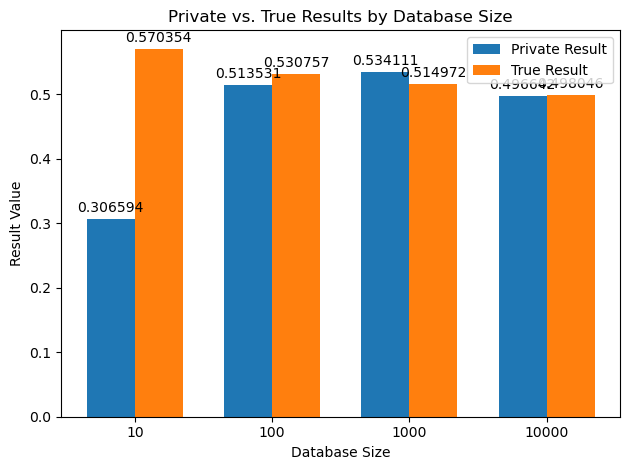

In [378]:
import numpy as np
import matplotlib.pyplot as plt
# Type your code here
sizes = torch.tensor([10, 100, 1000, 10000])
print(sizes)
privateResults = []
trueResults = []
for size in sizes:
    db = torch.rand(size)
    privateRes, trueRes = query(db)
    privateResults.append(privateRes)
    trueResults.append(trueRes)

x = np.arange(len(sizes))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, privateResults, width, label='Private Result')
rects2 = ax.bar(x + width/2, trueResults, width, label='True Result')

ax.set_xlabel('Database Size')
ax.set_ylabel('Result Value')
ax.set_title('Private vs. True Results by Database Size')
ax.set_xticks(x)
ax.set_xticklabels(sizes.numpy())
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Varying Amounts of Noise

Let's augment the randomized response query (the one we just wrote) to allow for varying amounts of randomness to be added. Specifically, let's bias the coin flip to be higher or lower and then run the same experiment.

In [379]:
def query(db, noise=0.2):

    true_result = torch.mean(db.float())

    first_coin_flip = (torch.rand(len(db)) < noise).float()
    second_coin_flip = (torch.rand(len(db)) < 0.5).float()

    augmented_database = db.float() * first_coin_flip + \
        (1 - first_coin_flip) * second_coin_flip

    sk_result = augmented_database.float().mean()

    private_result = ((sk_result / noise) - 0.5) * noise / (1 - noise)

    return private_result, true_result

### Task 5: Show how the private result (with noise) and the true result (without noise) changes for databases of size 10, 100, 1000, and 10000 with varying noise levels (noise=[0.1, 0.2, ..., 0.9]). (5 points)
*Hint: A convenience function for plotting results is provided for you.*

In [380]:
import matplotlib.pyplot as plt


def plot_results(db_size, noises, private_results, true_results):
    # plots the results on varying noise levels on a specific database size

    plt.scatter(noises, private_results, color="blue", label="With Noise")
    plt.scatter(noises, true_results, color="red", label="Without Noise")

    plt.xlabel("Noise")
    plt.ylabel("Results")
    plt.title("DB Size : " + str(db_size))

    plt.legend()

    plt.show()

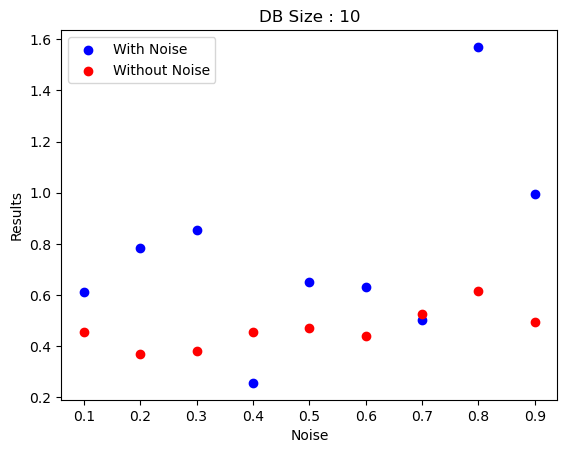

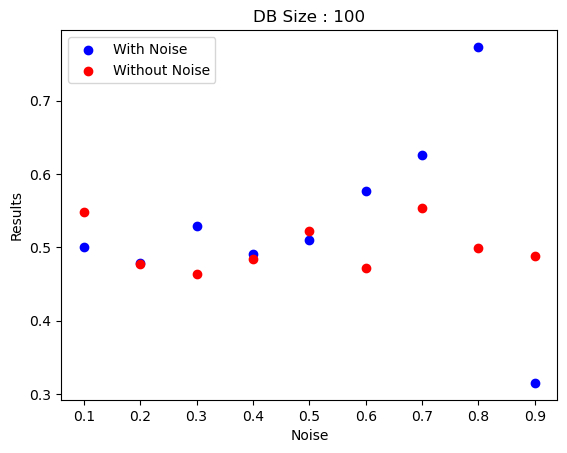

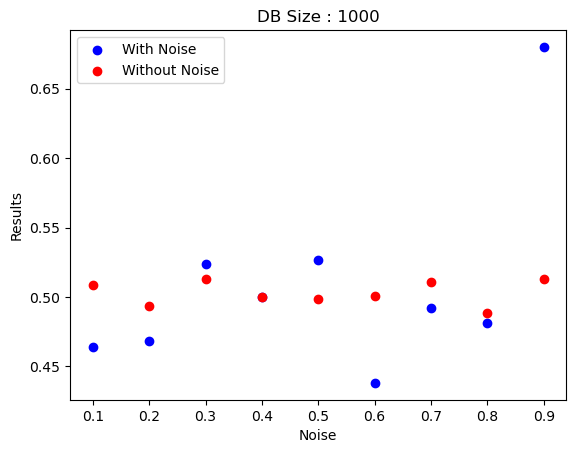

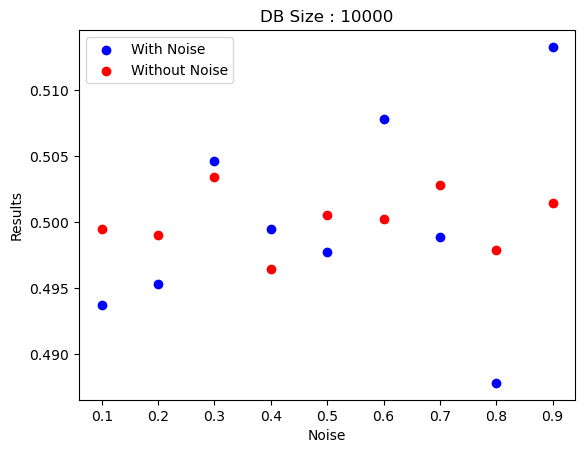

In [381]:
def noise(sizes, noises):
    for size in sizes:
        private_results = []
        true_results = []
        for noise in noises:
            db = torch.rand(size)
            private_result, true_result = query(db, noise)
            private_results.append(private_result)
            true_results.append(true_result)
        plot_results(size, noises, private_results, true_results)


noises = [(i + 1) / 10 for i in range(9)]
sizes = [10, 100, 1000, 10000]
noise(sizes, noises)

## The Formal Definition of Differential Privacy

The previous method of adding noise was called "Local Differential Privacy" because we added noise to each data point individually. This is necessary for some situations wherein the data is so sensitive that individuals do not trust noise to be added later. However, it comes at a very high cost in terms of accuracy.

However, alternatively, we can add noise after a function has aggregated data. This kind of noise can allow for similar levels of protection with a lower effect on accuracy. However, participants must be able to trust that no one looked at their data points before the aggregation took place. In some situations, this works out well, but it is less realistic in others (such as an individual hand-surveying a group of people).

Nevertheless, global differential privacy is incredibly important because it allows us to perform differential privacy on smaller groups of individuals with lower amounts of noise. Let's revisit our sum functions.

In [382]:
db, pdbs = create_db_and_parallels(100)


def query(db):
    return torch.sum(db.float())


def M(db):
    query(db) + noise


query(db)

tensor(47.)

The idea here is that we want to add noise to the output of our function. We can add two different kinds of noise - Laplacian Noise and Gaussian Noise. However, before we do so, we need to dive into the formal definition of Differential Privacy.

### Epsilon
Let's unpack the intuition of this for a moment.

**Epsilon Zero**: If a query satisfied this inequality where epsilon was set to 0, then that would mean that the query for all parallel databases outputs the same value as the full database. 

**Epsilon One**: If a query satisfied this inequality with epsilon 1, then the maximum distance between all queries would be 1 - or more precisely - the maximum distance between the two random distributions M(x) and M(y) is 1 (because all these queries have some amount of randomness in them, just like we observed in the last section).

### Delta

Delta is the probability that epsilon breaks. Namely, sometimes the epsilon is different for some queries than others. 

## How To Add Noise for Global Differential Privacy

Let's learn how to take a query and add varying amounts of noise to satisfy a certain degree of differential privacy. In particular, we will leave behind the previously discussed Local Differential privacy and instead focus on Global differential privacy.

To sum up, this is about adding noise to our query's output to satisfy a certain epsilon-delta differential privacy threshold.

We can add two kinds of noise - Gaussian Noise and Laplacian Noise. Generally speaking, Laplacian is better, but both are still valid. 

How much noise should we add?
The amount of noise necessary to add to the output of a query is a function of four things:
1. the type of noise (Gaussian/Laplacian)
2. the sensitivity of the query/function
3. the desired epsilon (ε)
4. the desired delta (δ)

Laplacian noise is increased/decreased according to a "scale" parameter b. We choose "b" based on the following formula.

b = sensitivity(query) / epsilon

In other words, if we set b to be this value, we know we will have a privacy leakage <= epsilon. Furthermore, the nice thing about Laplace is that it guarantees this with delta == 0. However, we can tune the parameters such that we have very low epsilon where the delta is non-zero, but we'll ignore them for now.

If we query the database multiple times - we can add the epsilons (even if we change the amount of noise and their epsilons are not the same).

## Create a Differentially Private Query

Let's create a query function that sums over the database and adds just the right amount of noise to satisfy an epsilon constraint. 

In [383]:
import numpy as np

epsilon = 0.0001

db, pdbs = create_db_and_parallels(100)


def sum_query(db):
    return db.sum()


def mean_query(db):
    return torch.mean(db.float())


def laplacian_mechanism(db, query, sensitivity):

    beta = sensitivity / epsilon
    noise = torch.tensor(np.random.laplace(0, beta, 1))

    return query(db) + noise

In [384]:
laplacian_mechanism(db, sum_query, 1)

tensor([3675.9634], dtype=torch.float64)

In [385]:
laplacian_mechanism(db, mean_query, 1/100)

tensor([153.0858], dtype=torch.float64)

# Differential Privacy for Deep Learning

## An Example Scenario: A Health Neural Network

Let's consider a scenario - you work for a hospital and have a large collection of images of your patients. However, you do not know what's in them. You would like to use these images to develop a neural network to classify them automatically. However, since your images aren't labeled, they aren't sufficient to train a classifier.

However, you realize you can reach out to 10 partner hospitals with annotated data. You plan to train your new classifier on their datasets so that you can automatically label your own. While these hospitals are interested in helping, they have privacy concerns regarding patient information. Thus, you will use the following technique to train a classifier that protects patients' privacy in the other hospitals.

1. You ask each of the 10 hospitals to train a model on their datasets (all of which have the same labels).
2. Use each of the 10 partner models on your local dataset, generating 10 labels for each of your data points.
3. For each local data point (now with 10 labels), you perform a DP query to generate the final true label. This query is a "max" function, where "max" is the most frequent label across the 10 labels. You need to add laplacian noise to make this "Differentially Private" to a certain epsilon/delta constraint.
4. Finally, you retrain a new model on your local dataset, which now has labels. This trained model will be our final "Differentially Private" model.

Assuming you're already familiar with how to train/predict a deep neural network, we'll skip steps 1 and 2 and work with example data. We'll focus instead on step 3, namely how to perform the DP query for each example using toy data.

So, let's say we have 10,000 training examples, and we've got 10 labels for each example (from our 10 "teacher models," which were trained directly on private data). Each label is chosen from 10 possible labels (categories) for each image.

In [386]:
import numpy as np

num_teachers = 10  # we're working with 10 partner hospitals
num_examples = 10000  # the size of OUR dataset
num_labels = 10  # number of lablels for our classifier

In [387]:
preds = (np.random.rand(num_teachers, num_examples) *
         num_labels).astype(int).transpose(1, 0)  # fake predictions
preds

array([[8, 1, 2, ..., 1, 3, 2],
       [7, 5, 3, ..., 8, 6, 0],
       [4, 1, 6, ..., 9, 4, 2],
       ...,
       [2, 0, 0, ..., 7, 7, 0],
       [8, 5, 0, ..., 4, 0, 9],
       [3, 0, 8, ..., 9, 7, 2]])

Prediction for the first data item from all the teachers.

In [388]:
preds[0]

array([8, 1, 2, 0, 1, 5, 5, 1, 3, 2])

All the predictions from the first teacher.

In [389]:
preds[:, 0]

array([8, 7, 4, ..., 2, 8, 3])

### Task 6: Combine these label predictions in a differentially private way. You may use an epsilon value of 0.1. (10 Points)

In [390]:
from numpy.random import laplace
from scipy.stats import mode
import numpy as np

epsilon = 0.1
modes, _ = mode(preds, axis=1)
initial_predictions = modes.flatten()

noise = laplace(loc=0, scale=1/epsilon, size=initial_predictions.shape)
noisy_predictions = initial_predictions + noise
noisy_predictions = np.clip(noisy_predictions, 0, num_labels - 1).astype(int)
print(noisy_predictions)

[9 1 0 ... 0 0 0]


# Federated Learning

Federated Learning is a machine learning technique that allows multiple clients to collaborate on a model training task without sharing their data with a central server. Instead, the clients train their models locally and exchange model updates with each other or with a central aggregator to improve the global model.

### Learning Objectives

By completing this part of the lab, you will learn:

* How to use PyTorch to implement a federated learning algorithm
* How to distribute the training process across multiple clients
* How to aggregate model weights from multiple clients to improve the global model performance
* How to evaluate the performance of a federated learning algorithm


### Set up the environment

We start by installing the required packages and importing the necessary modules.
It is highly recommended that you check out the [FedLab GitHub](https://github.com/SMILELab-FL/FedLab) repo and use the code directly from there.
Alternatively, using the following command, you can install fedlab and torchvision.

Reference: Tutorial for FedLab users (https://github.com/SMILELab-FL/FedLab/blob/master/tutorials/pipeline_tutorial.ipynb)

In [391]:
%pip install fedlab

Note: you may need to restart the kernel to use updated packages.


If you clone the FedLab GitHub repo, here's an example code snippet on how you may configure your environment.

In [392]:
import sys
# sys.path.append("../")

# configuration
from munch import Munch
from fedlab.models.mlp import MLP

from fedlab.utils.functional import evaluate
from fedlab.core.standalone import StandalonePipeline
from fedlab.utils.dataset import MNISTPartitioner

from torch import nn
from torch.utils.data import DataLoader, Subset
import torch
from torchvision import datasets, transforms
import torchvision

import matplotlib.pylab as plt


from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from fedlab.contrib.algorithm.basic_client import SGDSerialClientTrainer, SGDClientTrainer
from fedlab.contrib.algorithm.basic_server import SyncServerHandler
from fedlab.contrib.algorithm.basic_client import SerialClientTrainer
from fedlab.contrib.algorithm.basic_server import SyncServerHandler

### Task 7: Load the MNIST dataset [3 points]

You will be using the MNIST dataset for this lab. You may load the dataset using the TorchVision API or use Fedlab's version of the dataset.
FedLab provides the necessary module for users to partition their datasets. Additionally, various implementations of datasets partition for federated learning are available at the [URL](https://github.com/SMILELab-FL/FedLab/tree/master/datasets).

In [393]:
!mkdir ./datasets

mkdir: ./datasets: File exists


In [394]:
class DatasetManager:
    def __init__(self, base_dataset, partition_indices, batch_size):
        """
        Initializes the DatasetManager with the base dataset, partition indices, and a batch size.

        :param base_dataset: The base dataset from which subsets are created.
        :param partition_indices: A dictionary mapping client IDs to their respective dataset indices.
        :param batch_size: The batch size for DataLoader instances.
        """
        self.base_dataset = base_dataset
        self.partition_indices = partition_indices
        self.batch_size = batch_size
        self.data_loaders = self._create_data_loaders()

    def _create_data_loaders(self):
        """
        Private method to create a DataLoader for each partition (client).

        :return: A list of DataLoader instances, each corresponding to a client's dataset.
        """
        data_loaders = []
        # Ensure consistent order
        for client_id in sorted(self.partition_indices.keys()):
            indices = self.partition_indices[client_id]
            subset = Subset(self.base_dataset, indices)
            loader = DataLoader(
                subset, batch_size=self.batch_size, shuffle=True)
            data_loaders.append(loader)
        return data_loaders

    def get_dataloader(self, client_id, batch_size=0):
        """
        Returns a DataLoader for the specified client ID.

        :param client_id: The ID of the client for which to get the DataLoader.
        :return: A DataLoader object for the specified client's dataset.
        """
        return self.data_loaders[client_id]


transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

partitioner = MNISTPartitioner(mnist_train, 10)
datasets = DatasetManager(base_dataset=mnist_train,
                          partition_indices=partitioner.client_dict, batch_size=10)

Once you load the dataset, you may use the following function to visualize the digits.

In [395]:
IMAGE_SIZE = 28


def show_data(data_sample):
    """plot out data samples as images"""
    plt.imshow(data_sample[0].numpy().reshape(
        IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

### Task 8: Visualize a single digit [2 points]

Using the above function, visualize any digit in the dataset.

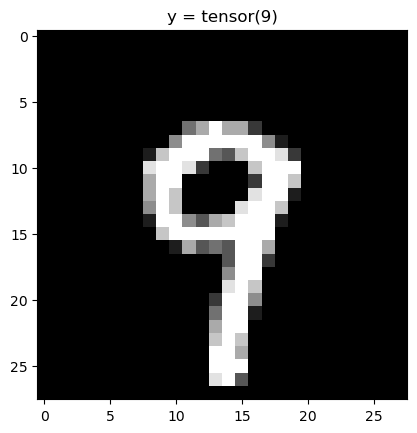

In [396]:
# Type your code here.
for images, labels in datasets.get_dataloader(0):
    show_data([images[9], labels[9]])
    break

### Task 9: Define the model architecture [5 points]
You should use PyTorch and the FedLab APIs to define your model architecture. 

*Hint: You can use a simple neural network or the `fedlab.models.mlp`.*

In [405]:
# Type your code here
# image size is 28 * 28 = 784
# possible number of outputs = 10
model = MLP(784, 10)
args = Munch

args.total_client = 10
args.alpha = 0.5
args.seed = 42
args.preprocess = True
args.cuda = "cpu"

### Task 10: Implement the client-side training logic [5 points]

Implement the client-side training logic, which should involve loading the local data, training the model on the local data, and sending the updated weights to the server. 

*Hint: For this task, you may use the `fedlab.contrib.algorithm.basic_client`.*

In [406]:
# client
# local train configuration
args.epochs = 5
args.batch_size = 128
args.lr = 0.1

trainer = SGDSerialClientTrainer(
    model, args.total_client, cuda=False)  # serial trainer
# trainer = SGDClientTrainer(model, cuda=True) # single trainer
client_loader = datasets
trainer.setup_dataset(client_loader)
trainer.setup_optim(args.epochs, args.batch_size, args.lr)

### Task 11: Implement the server-side aggregation logic [5 points]

Implement the server-side aggregation logic, which should involve receiving the updated weights from each client, aggregating the weights, and sending the updated global model weights back to each client. 

*Hint: You may use the `fedlab.contrib.algorithm.basic_server`.*

In [407]:
# server
# global configuration
args.com_round = 10
args.sample_ratio = 0.1

handler = SyncServerHandler(
    model=model, global_round=args.com_round, sample_ratio=args.sample_ratio, cuda=False)

### Task 12: Train the federated learning algorithm [5 points]

Once you have implemented the client-side training and server-side aggregation logic, you should train the model. 

*Hint: We recommend creating a subclass of the `fedlab.core.standalone.StandalonePipeline` for this purpose.*

In [408]:
def evaluate_local(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def evaluate_global(model, criterion, dataset_manager, device):
    total_loss = 0.0
    total_accuracy = 0.0
    totalClients = len(dataset_manager.data_loaders)

    for client_id, data_loader in enumerate(dataset_manager.data_loaders):
        avg_loss, accuracy = evaluate_local(
            model, criterion, data_loader, device)
        print(
            f"Client {client_id}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
        total_loss += avg_loss
        total_accuracy += accuracy

    global_avg_loss = total_loss / totalClients
    global_accuracy = total_accuracy / totalClients
    return global_avg_loss, global_accuracy

In [409]:
criterion = nn.CrossEntropyLoss()


class StandalonePipeline(object):
    def __init__(self, handler: SyncServerHandler, trainer: SerialClientTrainer):
        self.handler = handler
        self.trainer = trainer
        self.handler.num_clients = self.trainer.num_clients
        self.losses = []
        self.accuracies = []

    def main(self):
        while self.handler.if_stop is False:
            # server side
            sampled_clients = self.handler.sample_clients()
            broadcast = self.handler.downlink_package

            # client side
            self.trainer.local_process(broadcast, sampled_clients)
            uploads = self.trainer.uplink_package

            # server side
            for pack in uploads:
                self.handler.load(pack)
            loss, acc = evaluate_global(model, criterion, datasets, "cpu")
            self.losses.append(loss)
            self.accuracies.append(acc)

            # evaluate
            # return self.evaluate()
            # self.handler.evaluate()

### Task 13: Evaluate the federated learning algorithm [5 points]

Now, evaluate the performance of the federated learning algorithm. You can do this by computing the accuracy of the global model on the test set. You can also compare the performance of the federated learning algorithm with that of a centralized learning algorithm, where the data is collected and trained on a single server.

Use the convenience functions below for your evaluation.

In [410]:
def generate_loss_accuracy_charts(label, loss_list,  accuracy_list):

    fig, ax1 = plt.subplots()

    # create a subplot for the current key
    # ax = fig.add_subplot(len(data1), 1, i+1)

    color = 'tab:green'
    ax1.set_xlabel('epoch', color=color)

    color = 'tab:red'
    ax1.plot(loss_list, color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)

    ax1.set_title(label)

    fig.tight_layout()

    # show the figure
    plt.show()

In your analysis, you could analyze misclassified images using the following function.

In [411]:
def print_first_five_misclassified_samples(dataset, model):
    Softmax_fn = nn.Softmax(dim=-1)
    count = 0
    for x, y in dataset:
        z = model(x.unsqueeze(0))
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x, y))
            plt.show()
            print("yhat:", yhat)
            print("probability of class ", torch.max(Softmax_fn(z)).item())
            count += 1
        if count >= 5:
            break

Client 0: Loss = 2.3011, Accuracy = 10.55%
Client 1: Loss = 2.2996, Accuracy = 10.78%
Client 2: Loss = 2.3015, Accuracy = 10.80%
Client 3: Loss = 2.3015, Accuracy = 10.23%
Client 4: Loss = 2.2991, Accuracy = 11.47%
Client 5: Loss = 2.3007, Accuracy = 10.20%
Client 6: Loss = 2.3013, Accuracy = 10.23%
Client 7: Loss = 2.3016, Accuracy = 10.45%
Client 8: Loss = 2.3014, Accuracy = 10.52%
Client 9: Loss = 2.3010, Accuracy = 10.97%
Client 0: Loss = 2.3011, Accuracy = 10.55%
Client 1: Loss = 2.2996, Accuracy = 10.78%
Client 2: Loss = 2.3015, Accuracy = 10.80%
Client 3: Loss = 2.3015, Accuracy = 10.23%
Client 4: Loss = 2.2991, Accuracy = 11.47%
Client 5: Loss = 2.3007, Accuracy = 10.20%
Client 6: Loss = 2.3013, Accuracy = 10.23%
Client 7: Loss = 2.3016, Accuracy = 10.45%
Client 8: Loss = 2.3014, Accuracy = 10.52%
Client 9: Loss = 2.3010, Accuracy = 10.97%
Client 0: Loss = 2.3011, Accuracy = 10.55%
Client 1: Loss = 2.2996, Accuracy = 10.78%
Client 2: Loss = 2.3015, Accuracy = 10.80%
Client 3: L

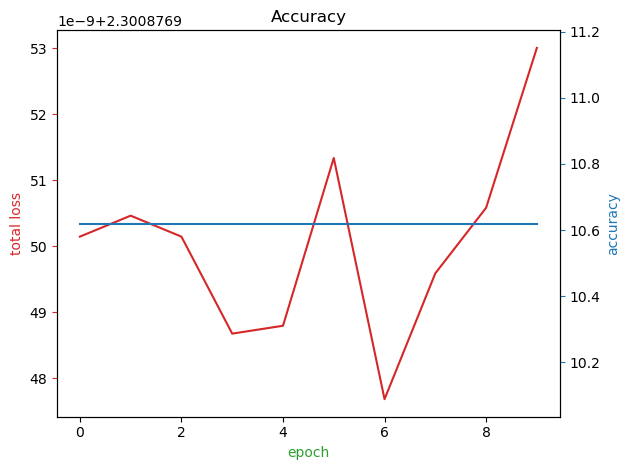

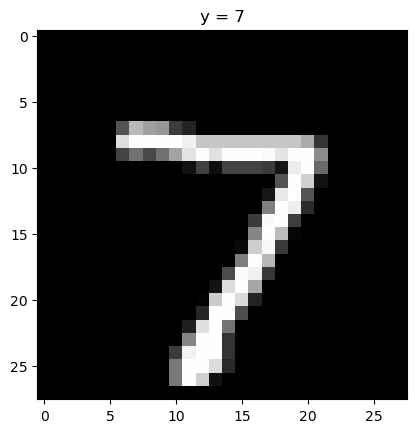

yhat: tensor([8])
probability of class  0.10838906466960907


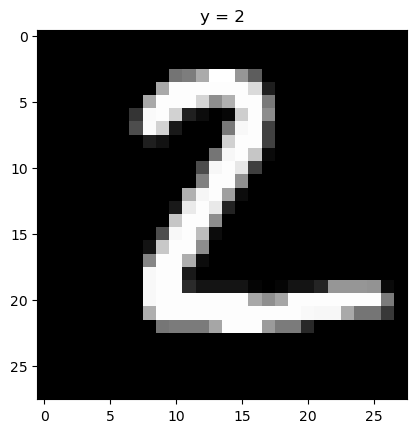

yhat: tensor([8])
probability of class  0.10915305465459824


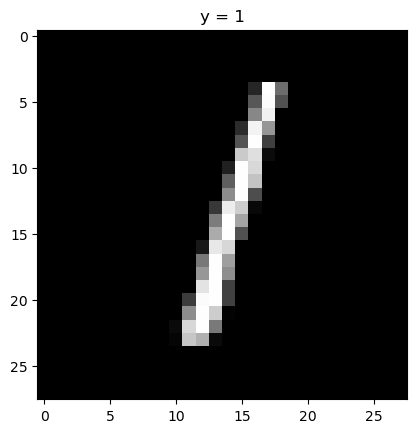

yhat: tensor([8])
probability of class  0.1089107021689415


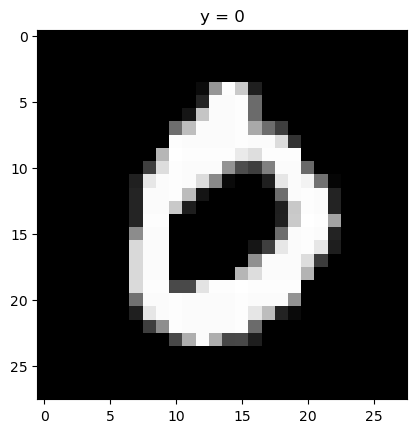

yhat: tensor([8])
probability of class  0.11156115680932999


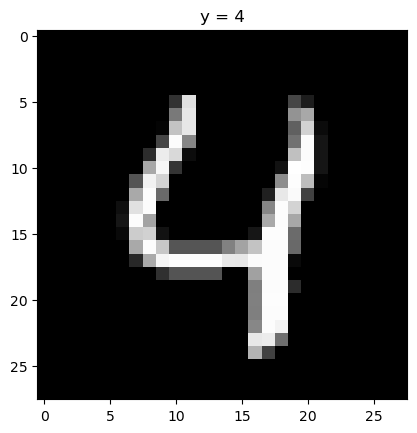

yhat: tensor([8])
probability of class  0.10893209278583527


In [412]:
# Type your code here.
pipeline = StandalonePipeline(handler, trainer)
pipeline.main()
generate_loss_accuracy_charts("Accuracy", pipeline.losses, pipeline.accuracies)
print_first_five_misclassified_samples(mnist_test, model)

### Task 14: Fine-tune the hyperparameters [5 points]

You should experiment with different hyperparameters to improve the performance of the federated learning algorithm. 

*Hint: You can try adjusting the num clients, learning rate, the batch size, or the number of communication rounds.*



In [416]:
def parameterVariation(totalClients, learning_rates, batch_sizes):
    for clients in totalClients:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(
                    f"Running experiment with {clients} clients, LR={lr}, Batch Size={batch_size}")

                # Partition the dataset
                print(clients)
                partitioner = MNISTPartitioner(mnist_train, clients)
                dataset_manager = DatasetManager(base_dataset=mnist_train,
                                                 partition_indices=partitioner.client_dict,
                                                 batch_size=batch_size)

                # Initialize model and trainer
                model = MLP(784, 10)
                args = Munch(epochs=5, lr=lr, batch_size=batch_size,
                             total_client=clients, cuda="cpu")
                trainer = SGDSerialClientTrainer(model, clients, cuda=False)
                trainer.setup_dataset(dataset_manager)
                trainer.setup_optim(args.epochs, args.batch_size, args.lr)

                # Initialize server handler
                handler = SyncServerHandler(
                    model=model, global_round=10, sample_ratio=0.1, cuda=False)

                # Run standalone pipeline
                pipeline = StandalonePipeline(handler, trainer)
                pipeline.main()

                # Evaluate the model
                criterion = nn.CrossEntropyLoss()
                loss, acc = evaluate_global(
                    model, criterion, dataset_manager, "cpu")
                print(f"Global Loss: {loss}, Global Accuracy: {acc}%")

In [ ]:
# Example hyperparameter ranges
totalClients = [10, 20]
learning_rates = [0.01, 0.1]
batch_sizes = [32, 64]

# Run the experiment
parameterVariation(totalClients, learning_rates, batch_sizes)

### Task 15: A description of the federated learning algorithm you implemented. [5 points]


The Federated Learning algorithm that I implemented required using FEDLab and PyTorch for the MNIST dataset with a Multi-Layer Perceptron (MLP) model. It partitions the dataset among a provided number of clients, ensuring data privacy by keeping training local and sharing only model updates with the server. This means neither the server nor other clients can see the data. The server aggregates these updates using SyncServerHandler to improve the global model across communication rounds. Client-side training uses SGDSerialClientTrainer for local model updates with Stochastic Gradient Descent, and the entire federated process is managed by StandalonePipeline. The StandalonePipeline is responsible for communication between clients and the server, as well as the final model evaluation. Because this setup can have any number of clients: it is a scalable, privacy-preserving approach to training ML models across distributed datasets. It also allows for flexible adjustments to training parameters, and of course ensures privacy by design.

### Task 16: A summary of the performance of the federated learning algorithm [5 points]

I evaluated the performance of this algorithm by analyzing the output of the hyperparameter variation above. Regardless of the parameters, the loss is steady at 2.3. The accuracy, on the other hand, fluctuates to a minimum of 7.17% and a maximum of 14.02% an output snippet is as follows:  <br>
Global Loss: 2.3065285139895497, Global Accuracy: 9.351666666666668% <br>
Running experiment with 10 clients, LR=0.1, Batch Size=32 <br>
Client 0: Loss = 2.3021, Accuracy = 11.27% <br>
Client 1: Loss = 2.3019, Accuracy = 11.08% <br>
Client 2: Loss = 2.3018, Accuracy = 10.88% <br>
Client 3: Loss = 2.3021, Accuracy = 10.12% <br>
Client 4: Loss = 2.3008, Accuracy = 11.55% <br>
Client 5: Loss = 2.3013, Accuracy = 11.65% <br>
Client 6: Loss = 2.3014, Accuracy = 11.22% <br>
Client 7: Loss = 2.3018, Accuracy = 11.50% <br>
Client 8: Loss = 2.3022, Accuracy = 10.88% <br>
Client 9: Loss = 2.3025, Accuracy = 11.20% <br>
Client 0: Loss = 2.3021, Accuracy = 11.27% <br>
Client 1: Loss = 2.3019, Accuracy = 11.08% <br>
Client 2: Loss = 2.3018, Accuracy = 10.88% <br>
Client 3: Loss = 2.3021, Accuracy = 10.12% <br>
Client 4: Loss = 2.3008, Accuracy = 11.55% <br>
Client 5: Loss = 2.3013, Accuracy = 11.65% <br>
Client 6: Loss = 2.3014, Accuracy = 11.22% <br>
Client 7: Loss = 2.3018, Accuracy = 11.50% <br>
Client 8: Loss = 2.3022, Accuracy = 10.88% <br>
Client 9: Loss = 2.3025, Accuracy = 11.20% <br>
Client 0: Loss = 2.3021, Accuracy = 11.27% <br>
Client 1: Loss = 2.3019, Accuracy = 11.08% <br>
Client 2: Loss = 2.3018, Accuracy = 10.88% <br>
Client 3: Loss = 2.3021, Accuracy = 10.12% <br>
Client 4: Loss = 2.3008, Accuracy = 11.55% <br>
Client 5: Loss = 2.3013, Accuracy = 11.65% <br>
Client 6: Loss = 2.3014, Accuracy = 11.22% <br>
Client 7: Loss = 2.3018, Accuracy = 11.50% <br>
Client 8: Loss = 2.3022, Accuracy = 10.88% <br>
Client 9: Loss = 2.3025, Accuracy = 11.20% <br>

### Task 17: A comparison of the performance of the federated learning algorithm with the performance of a centralized learning algorithm [5 points]

*Hint: To implement centralized training you set num client to be 1 and try out a few different learning rates.*

*Hint: You must also provide a written answer in markdown syntax analyzing the results you obtained.*

In [420]:
totalClients = [1]
learning_rates = [10]
batch_sizes = [64]

# Run the experiment
parameterVariation(totalClients, learning_rates, batch_sizes)

Running experiment with 1 clients, LR=10, Batch Size=64
Client 0: Loss = 2.3011, Accuracy = 10.55%
Client 1: Loss = 2.2996, Accuracy = 10.78%
Client 2: Loss = 2.3015, Accuracy = 10.80%
Client 3: Loss = 2.3015, Accuracy = 10.23%
Client 4: Loss = 2.2991, Accuracy = 11.47%
Client 5: Loss = 2.3007, Accuracy = 10.20%
Client 6: Loss = 2.3013, Accuracy = 10.23%
Client 7: Loss = 2.3016, Accuracy = 10.45%
Client 8: Loss = 2.3014, Accuracy = 10.52%
Client 9: Loss = 2.3010, Accuracy = 10.97%
Client 0: Loss = 2.3011, Accuracy = 10.55%
Client 1: Loss = 2.2996, Accuracy = 10.78%
Client 2: Loss = 2.3015, Accuracy = 10.80%
Client 3: Loss = 2.3015, Accuracy = 10.23%
Client 4: Loss = 2.2991, Accuracy = 11.47%
Client 5: Loss = 2.3007, Accuracy = 10.20%
Client 6: Loss = 2.3013, Accuracy = 10.23%
Client 7: Loss = 2.3016, Accuracy = 10.45%
Client 8: Loss = 2.3014, Accuracy = 10.52%
Client 9: Loss = 2.3010, Accuracy = 10.97%
Client 0: Loss = 2.3011, Accuracy = 10.55%
Client 1: Loss = 2.2996, Accuracy = 10.78

Type your answer here (this is a written answer, use markdown syntax as necessary).
The algorithm performs different with different numbers of participants. Because there is theoretically more data from broader sources the accuracy should increase as the number of participants increases. the loss would decrease as it has more data assuming the data is good. if there is a lot of noise in the data this could cause the loss to slightly increase with more participants/data.

### Task 18: A discussion of the hyperparameters you fine-tuned and their impact on the performance of the federated learning algorithm [5 points]

I fine tuned 3 different parameters, the first is the number of clients, second is the learning rate, and third is the batch size. Batch size had the least affect on performance with number of clients being the most effective. The sample output file shows the variation in accuracy and loss with changes to the hyperparameters.

### Task 19: Implement the aggregator using a Solidity smart contract. [10 points]
You must write Solidity code to get full points for this question. The contract should be syntactically correct (i.e., compile).

Some Hints: 
* Create structs for the Participants (i.e., clients) and Global Model (i.e., the server). 
* Some useful functions to include in the smart contract: addParticipant, updateParticipantParameters, aggregate
* The `aggregate` function should aggregate the model parameters from all the participants, and you are welcome to utilize any relevant algorithm for this purpose.

Since the code is in Solidity, place it inside the markdown cell in the "javascript" environment.

```javascript
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract FederatedLearningAggregator {
    struct Participant {
        uint256[] contributions;
    }

    mapping(address => Participant) private participants;
    address[] private participantAddresses;
    address private owner;

    event ParticipantAdded(address participant);
    event ParametersUpdated(address participant);
    event ContributionsConcatenated(uint256[] concatenatedContributions);

    constructor() {
        owner = msg.sender;
    }

    modifier ownerOnly() {
        require(msg.sender == owner, "Owner only");
        _;
    }

    function addParticipant() external {
        require(participants[msg.sender].contributions.length == 0, "Participant already exists.");
        participantAddresses.push(msg.sender);
        emit ParticipantAdded(msg.sender);
    }

    function updateParticipantParameters(uint256[] calldata _contributions) external {
        require(participants[msg.sender].contributions.length != 0, "Participant does not exist.");
        participants[msg.sender].contributions = _contributions;
        emit ParametersUpdated(msg.sender);
    }

    function getParticipantContributions(address participant) external view returns (uint256[] memory) {
        return participants[participant].contributions;
    }

    function aggregateContributions() external ownerOnly returns (uint256[] memory){
        uint256 totalLength = 0;

        for (uint256 i = 0; i < participantAddresses.length; i++) {
            totalLength += participants[participantAddresses[i]].contributions.length;
        }

        uint256[] memory concatenatedContributions = new uint256[](totalLength);
        uint256 currentIndex = 0;
        for (uint256 i = 0; i < participantAddresses.length; i++) {
            uint256[] memory currentContributions = participants[participantAddresses[i]].contributions;
            for (uint256 j = 0; j < currentContributions.length; j++) {
                concatenatedContributions[currentIndex++] = currentContributions[j];
            }
        }

        emit ContributionsConcatenated(concatenatedContributions);
        return concatenatedContributions;
    }
}

```


### Task 20: Deploying and using the aggregator smart contract. [5 points]
Please describe the steps you would take to deploy the smart contract you developed above on an Ethereum test network (you need not deploy the contract). How would the participants/clients interact with the smart contract?

Type your answer here (this is a written answer, use markdown syntax as necessary).

The owner of the contract would deploy it on the test network. Then each participant would run the addParticipant function. this would allow them to submit to the aggregator. Then once they have run the model locally they will update their parameters by submitting them in an array (assuming the parameters are integers) to the updateParticipantParameters. the owner can then aggregate the participants parameters and get the concatenated contributions.